In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
from itertools import product

In [2]:
def score_graph(df, score, class_name, color):
    row, col = 1, 8
    fig, axs = plt.subplots(row, col, figsize=(20, 3))
    for i, c in C.items():
        axs[i].hist(df[score][df[class_name] == c], range(0, 500 ,40), color=color)
        axs[i].set_ylim(0, 20)
        axs[i].set_xlabel('Score')
        axs[i].set_ylabel('Num')
        axs[i].set_title(f'Class {c}')
    plt.tight_layout()
    plt.show()

In [3]:
students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
student_pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])
display(students_df.head(3))
student_pairs_df.head(3)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [4]:
S = students_df['student_id']
MAX_STUDENTNS = 40
class_num = math.ceil(students_df.shape[0] / MAX_STUDENTNS)
C = {i: chr(65+i) for i in range(class_num)}
SC = [(s, c) for s in S for c in C.values()]
S_men = students_df['student_id'][students_df['gender'] == 0]
S_women = students_df['student_id'][students_df['gender'] == 1]
S_leader = students_df['student_id'][students_df['leader_flag'] == 1]
S_support = students_df['student_id'][students_df['support_flag'] == 1]
score_mean = students_df['score'].mean()
S_score = {row.student_id: row.score for row in students_df.itertuples()}
S_spec = [(row.student_id1, row.student_id2) for row in student_pairs_df.itertuples()]

students_df['rank'] = students_df['score'].rank(method='first', ascending=False)
students_df['init_class'] = students_df['rank'].map(lambda x: x % class_num).map(C)
init_flag = {(s, c): 0 for s in S for c in C.values()}
for row in students_df.itertuples():
    init_flag[row.student_id, row.init_class] = 1

In [5]:
m = LpProblem('class_organization', sense=LpMaximize)

x = LpVariable.dicts('x', SC, cat='Binary')

for s in S:
    m += lpSum(x[s, c] for c in C.values()) == 1

for c in C.values():
    m += lpSum(x[s, c] for s in S) >= 39
    m += lpSum(x[s, c] for s in S) <= 40
    m += lpSum(x[s, c] for s in S_men) <= 20
    m += lpSum(x[s, c] for s in S_women) <= 20
    m += lpSum(x[s, c] for s in S_leader) >= 2
    m += lpSum(x[s, c] for s in S_support) <= 1

    m += (score_mean - 10) * lpSum(x[s, c] for s in S) <= lpSum(x[s, c] * S_score[s] for s in S)
    m += (score_mean + 10) * lpSum(x[s, c] for s in S) >= lpSum(x[s, c] * S_score[s] for s in S)

for s1, s2 in S_spec:
    for c in C.values():
        m += x[s1, c] + x[s2, c] <= 1

m += lpSum(x[s, c] * init_flag[s, c] for s, c in SC)

status = m.solve()
print(LpStatus[status])

Optimal


In [6]:
class_organization = {}
for c in C.values():
    class_students = [s for s in S if x[s, c].value() == 1]
    class_organization[c] = class_students
for k, v in class_organization.items():
    print(k, len(v), v)

A 40 [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]
B 39 [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]
C 40 [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]
D 40 [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]
E 39 [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203, 234, 235, 240, 241, 249, 251, 254, 256, 261, 266, 268, 276, 283, 291, 294, 302]
F 40 [1, 6, 16, 27, 28, 29, 40, 42, 45, 58,

In [7]:
result_df = students_df.copy()
S2C = {s: c for s in S for c in C.values() if x[s, c].value() == 1}
result_df['class'] = result_df['student_id'].map(S2C)
result_df.head()

print(result_df.groupby('class').count()['student_id'].to_list())
print(result_df.groupby(['class', 'gender']).count()['student_id'].to_list())
print(result_df.groupby(['class', 'leader_flag']).count()['student_id'].to_list())
print(result_df.groupby(['class', 'support_flag']).count()['student_id'].to_list())
print(result_df.groupby(['class']).mean(numeric_only=True)['score'].to_list() - score_mean)
for s1, s2 in S_spec:
    print(S2C[s1] == S2C[s2], f'{s1:03}', S2C[s1], f'{s2:03}', S2C[s2], end=', ')

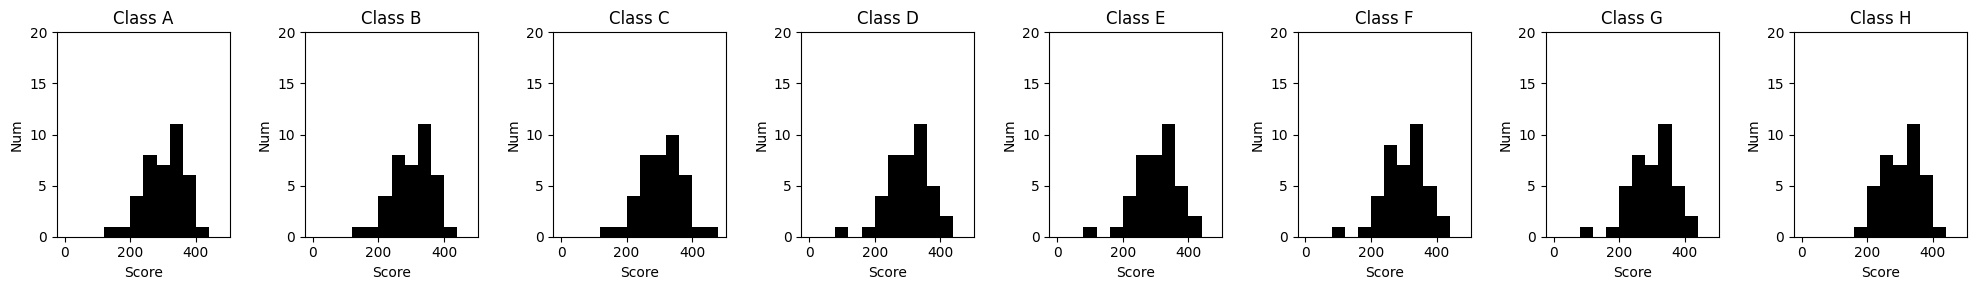

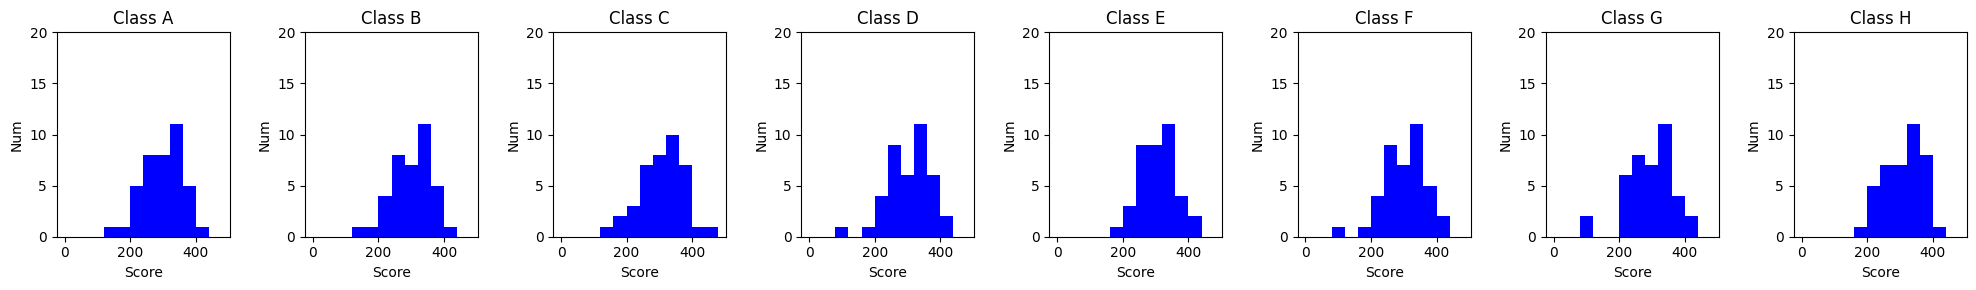

In [9]:
score_graph(students_df, 'score', 'init_class', 'k')
score_graph(result_df, 'score', 'class', 'b')